In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [5]:
dfData = pd.read_csv('/home/soledad-escobar/Descargas/Orga_datos/fiuba-trocafone-tp2-final-set/events_up_to_01062018.csv')
dfTrain = pd.read_csv('/home/soledad-escobar/Descargas/Orga_datos/fiuba-trocafone-tp2-final-set/labels_training_set.csv')
dfTest = pd.read_csv('/home/soledad-escobar/Descargas/Orga_datos/fiuba-trocafone-tp2-final-set/trocafone_kaggle_test.csv')
dfSample = pd.read_csv('/home/soledad-escobar/Descargas/Orga_datos/fiuba-trocafone-tp2-final-set/trocafone_kaggle_submit_sample_all_0.csv')

/home/soledad-escobar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Crea un df con todos los usuarios
dfTest['label'] = 0
dfUsers = pd.concat([dfTrain,dfTest])
dfTest = dfTest.drop('label', axis=1)

In [7]:
#Le asigna a cada usuario su cantidad de eventos dandole mas valor si son mas recientes
def pesoTiempo(time):
    mes = int(time[6])
    dia = int(time[8:10])
    if mes < 5:
        return 1
    return 10 + dia * 0.7
    
dfPE = dfData[['person', 'event', 'timestamp']]
dfPE['puntajeTiempo'] = dfPE['timestamp'].apply(pesoTiempo)
dfPE = pd.get_dummies(dfPE, columns=['event'])
dfPE = dfPE.drop(['event_generic listing', 'event_lead'], axis=1)
columnasEventos = dfPE.columns.values[3:]
for eventoColumna in columnasEventos:
    dfPE[eventoColumna] *= dfPE['puntajeTiempo']
dfPE = dfPE.drop(['timestamp', 'puntajeTiempo'], axis=1).groupby('person').sum()
dfUsers = dfUsers.sort_values('person').merge(dfPE, on='person')

/home/soledad-escobar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
#Le asigna a cada usuario la region en la que mas eventos tiene
regionesMasEventos = dfData['region'].value_counts().head(9).index.tolist()
def filtrarRegiones(region):
    if pd.isnull(region):
        return 'null'
    if region not in regionesMasEventos:
        return 'Other'
    return region
    
dfPE = dfData[['person', 'region']]
dfPE['regionAcotada'] = dfPE['region'].apply(filtrarRegiones)

lDictRegiones = []
temp = dfPE.drop('region', axis=1).groupby('person')
for name, group in temp:
    regiones = {'null' : 1}
    for row in group.itertuples():
        region = row.regionAcotada
        if region == 'null':
            continue
        if region in regiones:
            regiones[region] += 1
        else:
            regiones[region] = 1
        rMax = max(regiones, key=regiones.get)
    lDictRegiones.append({'person' : name, 'region' : rMax})

dfRegiones = pd.DataFrame(lDictRegiones)
dfRegiones = pd.get_dummies(dfRegiones, columns=['region'])
dfUsers = dfUsers.merge(dfRegiones, on='person')

/home/soledad-escobar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
#Casteo dfUsers a int32
personas = dfUsers['person']
dfUsers.drop('person', axis=1, inplace=True)
dfUsers = dfUsers.astype('int32')
dfUsers['person'] = personas

In [10]:
#Agrego columna con ultima visita al sitio
temp = dfData.groupby('person')['timestamp'].max().to_frame()
dfUsers = dfUsers.merge(temp, on='person')
dfUsers['month'] = dfUsers['timestamp'].str[5:7]
dfUsers['day'] = dfUsers['timestamp'].str[8:10]
dfUsers[['day','month']] = dfUsers[['day','month']].apply(pd.to_numeric)
dfUsers['last_visit'] = dfUsers['month']*30 + dfUsers['day']
dfUsers = dfUsers.drop(['timestamp','month','day'], axis=1)

In [11]:
#Agrego columna con ultima compra
temp = dfData.loc[dfData['event'].isin(['conversion','lead','checkout'])].groupby('person')['timestamp'].max().to_frame()
dfUsers = dfUsers.merge(temp, how='left', on='person')
dfUsers = dfUsers.fillna('000000000000000000')
dfUsers['month'] = dfUsers['timestamp'].str[5:7]
dfUsers['day'] = dfUsers['timestamp'].str[8:10]
dfUsers[['day','month']] = dfUsers[['day','month']].apply(pd.to_numeric)
dfUsers['last_conversion'] = dfUsers['month']*30 + dfUsers['day']
dfUsers = dfUsers.drop(['timestamp','month','day'], axis=1)

In [12]:
#Columna con relacion entre el uso del celular y de la computadora
def filtrarDispositivo(deviceType):
    if deviceType == 'Computer':
        return 1
    elif deviceType == 'Smartphone':
        return 0
    else:
        return 2
    
dfPE = dfData[['person', 'device_type']]
dfPE['dispositivo'] = dfPE['device_type'].apply(filtrarDispositivo)
dfPE = dfPE.loc[dfPE['dispositivo'] != 2].drop('device_type', axis=1).groupby('person').mean()
dfUsers = dfUsers.merge(dfPE, on='person', how='left').fillna(0)

/home/soledad-escobar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
#Feature storage
dfT = dfData.loc[dfData['event'] == 'viewed product'][['person', 'storage']].dropna()
dfT = dfT.loc[dfT['storage'] != '256GB']
dfT = dfT.loc[dfT['storage'] != '4GB']
dfT = dfT.loc[dfT['storage'] != '512MB']
dfT = dfT.loc[dfT['storage'] != '8GB']
dfT = dfT.loc[dfT['storage'] != '128GB']
dfQChannels = dfT.groupby('person')['storage'].count().to_frame()
dfPE = pd.get_dummies(dfT, columns=['storage']).groupby('person').sum()
columnasCanales = dfPE.columns.values
dfPE = dfPE.merge(dfQChannels, on='person')
for canalColumna in columnasCanales:
    dfPE[canalColumna] /= dfPE['storage']
dfPE = dfPE.drop('storage', axis=1)
dfUsers = dfUsers.merge(dfPE, on='person', how='left').fillna(0)

# Gradient Boosting 

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

df_y = dfTrain['label']
df_X = dfTrain.drop('label', axis=1).merge(dfUsers, on='person').drop(['person','label'], axis=1)

GBC = GradientBoostingClassifier(random_state=23)
scores = cross_val_score(GBC , df_X, df_y, scoring="roc_auc", cv=5)
scores.mean()

0.8761745122773188

# XGBoost

In [15]:
#Pruebo con XGBoost
XGBC = xgb.XGBClassifier(learning_rate =0.075, n_estimators=95, max_depth=4, min_child_weight=6, 
                         gamma=0.3, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                         scale_pos_weight=0.8, seed = 15)

scores = cross_val_score(XGBC , df_X, df_y, scoring="roc_auc", cv=5)
scores.mean()

0.8755851275543354

# Voting Classifier

In [55]:
from sklearn.ensemble import VotingClassifier

VC = VotingClassifier(estimators=[('xgb', XGBC), ('gb', GBC)], voting='soft', weights = [1,1.1])
scores = cross_val_score(VC , df_X, df_y, scoring="roc_auc", cv=5)
scores.mean()

0.8770999258656941

# Agrego nuevos features

In [17]:
# Agrego columnas para separar los meses y la hora
datos = dfData.loc[:,['timestamp', 'event', 'person']]
datos['date_time'] = pd.to_datetime(datos['timestamp'], format='%Y%m%d %H:%M:%S.%f')
datos['mes'] = datos['date_time'].dt.month
datos['hora'] = datos['date_time'].dt.hour

In [24]:
#Agrego columnas para ver el momento del dia en el que se generaron las conversiones
features = datos.loc[ datos['event'] == 'conversion', ['person', 'hora']]
features['mañana'] = features['hora'].apply(lambda x: 1 if ((x >= 6) & (x < 12)) else 0)
features['tarde'] = features['hora'].apply(lambda x: 1 if ((x >= 12) & (x <20)) else 0)
features['noche'] = features['hora'].apply(lambda x: 1 if ((x >= 20) & (x <= 23) or (x >= 0) & (x < 2)) else 0)
features['madrugada'] = features['hora'].apply(lambda x: 1 if ((x >= 0) & (x < 6)) else 0)
features = features.drop('hora', axis = 'columns').groupby('person').sum()

In [25]:
# Hago un join con los features anteriores
df_feat = pd.merge(dfUsers, features, on = 'person', how = 'left').fillna(0.0).drop('label', axis = 'columns')
# Agrego la cantidad de eventos que generaron las personas
df_feat['total_events'] = (np.sum(df_feat.filter(items = ['event_ad campaign hit','event_brand listing', 'event_checkout', 
                                                         'event_conversion', 'event_search engine hit', 
                                                         'event_searched products', 'event_staticpage', 'event_viewed product','event_visited site']), 
    axis = 'columns'))

# XGBoost Classifier

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Me quedo solo con los datos de las pñersonas que tienen labels
df_features = df_feat.merge(dfTrain, on = 'person')

y = df_features['label']
X = df_features.drop(['person', 'label'], axis=1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2)

Realizo las predicciones y luego calculo el score

In [27]:
XGBC.fit(X_train, y_train)
preds = XGBC.predict_proba(X_test)[:,1]
preds

array([0.00306397, 0.36301678, 0.13303953, ..., 0.0034831 , 0.01838093,
       0.05467035], dtype=float32)

In [28]:
scores = cross_val_score(XGBC , X, y, scoring = "roc_auc", cv = 5)
scores.mean()

0.8731027009533994

Como el score bajó veo como mejorar mis features.

In [29]:
# Veo en que momento del día se realizan más compras
ranking = {'mañana': df_feat['mañana'].sum(), 'tarde': df_feat['tarde'].sum(), 'noche': df_feat['noche'].sum(), 'madrugada': df_feat['madrugada'].sum()}
ranking

{'mañana': 463.0, 'tarde': 3400.0, 'noche': 2585.0, 'madrugada': 1473.0}

Text(0.5,0,'Momento del día')

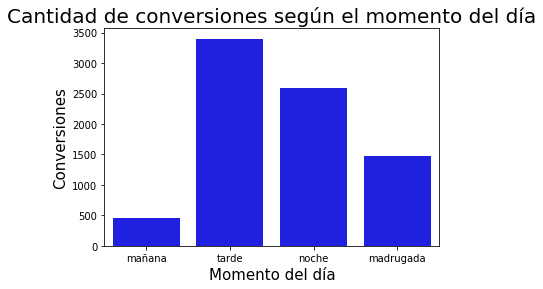

In [36]:
grafico = sns.barplot( x = list(ranking.keys()), y = list(ranking.values()), orient = 'v', color = 'blue')
grafico.set_title('Cantidad de conversiones según el momento del día', size = 20)
grafico.set_ylabel('Conversiones', size = 15)
grafico.set_xlabel('Momento del día', size = 15)

Quiero ver que pasa si agrego un feature con la relación entre la cantidad de conversiones realizadas sobre la cantidad de eventos totales

In [38]:
#Agrego una columna para calcular la cantidad de conversiones realizadas sobre el total de eventos relaizados
def calcular_posibilidad(x):
    if (x['total_events'] == 0): 
            return 0
    else:
        return (x['event_conversion']/x['total_events'])
    
df_feat['posible_conversion'] = df_feat.loc[:,['event_conversion','total_events']].apply(calcular_posibilidad, axis = 1)

In [39]:
# Me quedo solo con las personas que tienen labels
df_features_1 = df_feat.merge(dfTrain, on = 'person')

y1 = df_features_1['label']
X1 = df_features_1.drop(['person', 'label'], axis=1)

scores = cross_val_score(XGBC , X1, y1, scoring = "roc_auc", cv = 5)
scores.mean()

0.8743794590104301

Como en el ranking realizado se ve en que momentos del día se realizan más conversiones, creo columnas para asignar más peso a las conversiones "más posibles" segun el momento del dia en el que ingresa el usuario

In [48]:
df_feat['posib_conv_mañ'] = (df_feat['posible_conversion'] * 1.5)
df_feat['posib_conv_tar'] =(df_feat['posible_conversion'] * 10)
df_feat['posib_conv_noch'] = (df_feat['posible_conversion'] * 6)
df_feat['posib_conv_mad'] = (df_feat['posible_conversion'] * 3)

In [49]:
# Me quedo solo con las personas que tienen labels
df_features_2 = df_feat.merge(dfTrain, on = 'person')

y2 = df_features_2['label']
X2 = df_features_2.drop(['person', 'label'], axis=1)

scores = cross_val_score(XGBC , X2, y2, scoring = "roc_auc", cv = 5)
scores.mean()

0.8746047696554984

Como los nuevos features solo bajan aun más la precisión del algoritmo, los descarto

In [50]:
# Agrego la relación entre checkouts y conversiones
def relacion_conversion_checkout(df):
    if (df['event_checkout'] == 0):
        return 0
    else:
        return (df['event_conversion'] / df['event_checkout'])
df_feat['conversion/checkout'] = df_feat.loc[:,['event_conversion', 'event_checkout']].apply(relacion_conversion_checkout, axis = 1)

In [51]:
# Descarto los features anteriores
new_df_features = df_feat.drop(['posib_conv_mañ', 'posib_conv_tar', 'posib_conv_noch','posib_conv_mad'], axis = 1)

In [52]:
# Me quedo solo con las personas que tienen labels
df_features_3 = new_df_features.merge(dfTrain, on = 'person')

y3 = df_features_3['label']
X3 = df_features_3.drop(['person', 'label'], axis=1)

#XGBoost
scores = cross_val_score(XGBC , X3, y3, scoring = "roc_auc", cv = 5)
scores.mean()

0.8747884285015918

In [53]:
#Gradient Boosting
scores = cross_val_score(GBC , X3, y3, scoring = "roc_auc", cv = 5)
scores.mean()

0.8746641483320545

In [56]:
#Voting
scores = cross_val_score(VC , X3, y3, scoring="roc_auc", cv=5)
scores.mean()

0.8756004656826978

## Agrego más features sobre marcas y modelos de los productos

Como se tienen muchos modelos diferentes pero corresponden a una cantidad acotada de marcas, trabajo sobre las marcas para crear nuevos features. Creo una columna por cada marca existente y para cada persona coloco la suma de eventos para esa marca.

In [59]:
marcas = dfData.loc[:, ['model', 'person']]
marcas['Samsung'] = marcas['model'].apply(lambda x: 1 if ('samsung' in str(x).lower()) else 0)
marcas['iPhone'] = marcas['model'].apply(lambda x: 1 if ('iphone' in str(x).lower()) else 0)
marcas['Motorola'] = marcas['model'].apply(lambda x: 1 if ('moto' in str(x).lower()) else 0)
marcas['Lenovo'] = marcas['model'].apply(lambda x: 1 if ('lenovo' in str(x).lower()) else 0)
marcas['LG'] = marcas['model'].apply(lambda x: 1 if ('lg' in str(x).lower()) else 0)
marcas['Sony'] = marcas['model'].apply(lambda x: 1 if ('sony' in str(x).lower()) else 0)
marcas['Asus'] = marcas['model'].apply(lambda x: 1 if ('asus' in str(x).lower()) else 0)
marcas['iPad'] = marcas['model'].apply(lambda x: 1 if ('ipad' in str(x).lower()) else 0)
marcas['Quantum'] = marcas['model'].apply(lambda x: 1 if ('quantum' in str(x).lower()) else 0)
dfFeat = marcas.groupby('person').sum()

In [60]:
# Hago join con los features anteriores 
new_features = pd.merge(new_df_features, dfFeat, on = 'person', how = 'left').fillna(0.0)

Samsung     501307
iPhone      593603
Motorola    162914
Lenovo       11382
LG           24814
Sony         15599
Asus          4536
iPad          5663
Quantum       1693
dtype: int64

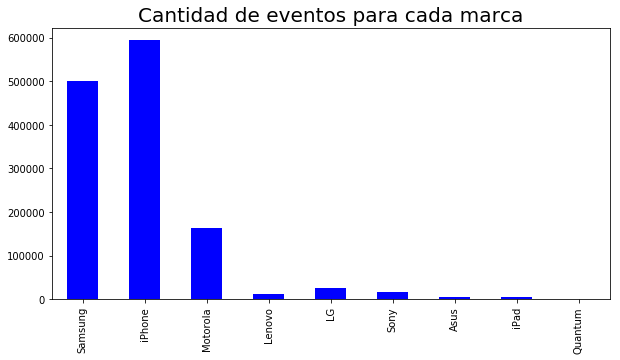

In [90]:
#Cantidad de eventos para cada marca
graph = dfFeat.sum().plot(kind = 'bar', color = 'blue', figsize = (10,5))
graph.set_title('Cantidad de eventos para cada marca', size = 20)
dfFeat.sum()

In [66]:
# Me quedo solo con las personas que tienen labels
df_features_4 = new_features.merge(dfTrain, on = 'person')

y4 = df_features_4['label']
X4 = df_features_4.drop(['person', 'label'], axis=1)

In [69]:
#XGBoost
scores = cross_val_score(XGBC , X4, y4, scoring = "roc_auc", cv = 5)
scores.mean()

0.875155747432659

In [70]:
#Gradient Boosting
scores = cross_val_score(GBC , X4, y4, scoring = "roc_auc", cv = 5)
scores.mean()

0.8751096607420038

In [71]:
#Voting
scores = cross_val_score(VC , X4, y4, scoring="roc_auc", cv=5)
scores.mean()

0.876104877735429

Creo nuevos features para la cantidad de compras
según la marca que visite el usuario

In [95]:
#Creo columnas para las compras por marcas existentes
compras_por_marcas = dfData.loc[dfData['event'] == 'conversion', ['model', 'person']]
compras_por_marcas['Samsung_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('samsung' in x.lower()) else 0)
compras_por_marcas['iPhone_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('iphone' in x.lower()) else 0)
compras_por_marcas['Motorola_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('moto' in x.lower()) else 0)
compras_por_marcas['Lenovo_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('lenovo' in x.lower()) else 0)
compras_por_marcas['LG_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('lg' in x.lower()) else 0)
compras_por_marcas['Sony_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('sony' in x.lower()) else 0)
compras_por_marcas['Asus_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('asus' in x.lower()) else 0)
compras_por_marcas['iPad_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('iPad' in x.lower()) else 0)
compras_por_marcas['Quantum_comp'] = compras_por_marcas['model'].apply(lambda x: 1 if ('quantum' in x.lower()) else 0)
features = compras_por_marcas.groupby('person').sum()

In [96]:
set_features = pd.merge(new_features, features, on = 'person', how = 'left').fillna(0.0)

Samsung_comp     3615
iPhone_comp      2024
Motorola_comp    1104
Lenovo_comp        99
LG_comp           161
Sony_comp          56
Asus_comp          22
iPad_comp           0
Quantum_comp        3
dtype: int64

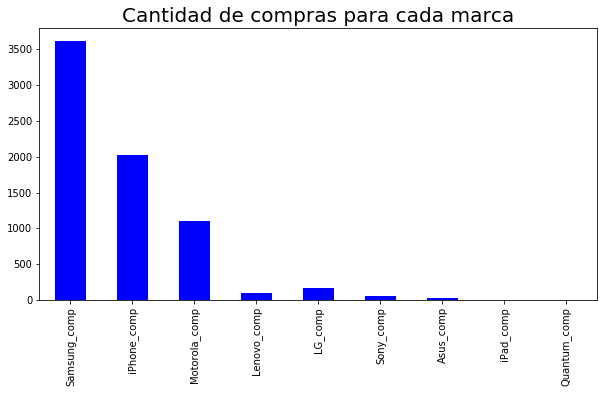

In [98]:
# Veo como se comportan las marcas segun la cantidad de compras
graph = features.sum().plot(kind = 'bar', color = 'blue', figsize = (10,5))
graph.set_title('Cantidad de compras para cada marca', size = 20)
features.sum()

In [74]:
# Me quedo solo con las personas que tienen labels
df_features_5 = set_features.merge(dfTrain, on = 'person')

y5 = df_features_5['label']
X5 = df_features_5.drop(['person', 'label'], axis=1)

In [75]:
#XGBoost
scores = cross_val_score(XGBC, X5, y5, scoring = "roc_auc", cv = 5)
scores.mean()

0.8753725122428344

In [76]:
#Gradient Boosting
scores = cross_val_score(GBC , X5, y5, scoring = "roc_auc", cv = 5)
scores.mean()

0.8742878478555938

In [77]:
#Voting
scores = cross_val_score(VC , X5, y5, scoring="roc_auc", cv=5)
scores.mean()

0.8756995981558358

In [78]:
new_set_features = new_features.drop(['mañana', 'tarde', 'noche', 'madrugada'], axis = 1)

In [79]:
# Me quedo solo con las personas que tienen labels
df_features_6 = new_set_features.merge(dfTrain, on = 'person')

y6 = df_features_6['label']
X6 = df_features_6.drop(['person', 'label'], axis=1)

In [80]:
#XGBoost
scores = cross_val_score(XGBC, X6, y6, scoring = "roc_auc", cv = 5)
scores.mean()

0.8762222041440783

In [81]:
#Gradient Boosting
scores = cross_val_score(GBC , X6, y6, scoring = "roc_auc", cv = 5)
scores.mean()

0.875484747941543

In [82]:
#Voting
scores = cross_val_score(VC , X6, y6, scoring="roc_auc", cv=5)
scores.mean()

0.8767968841444864

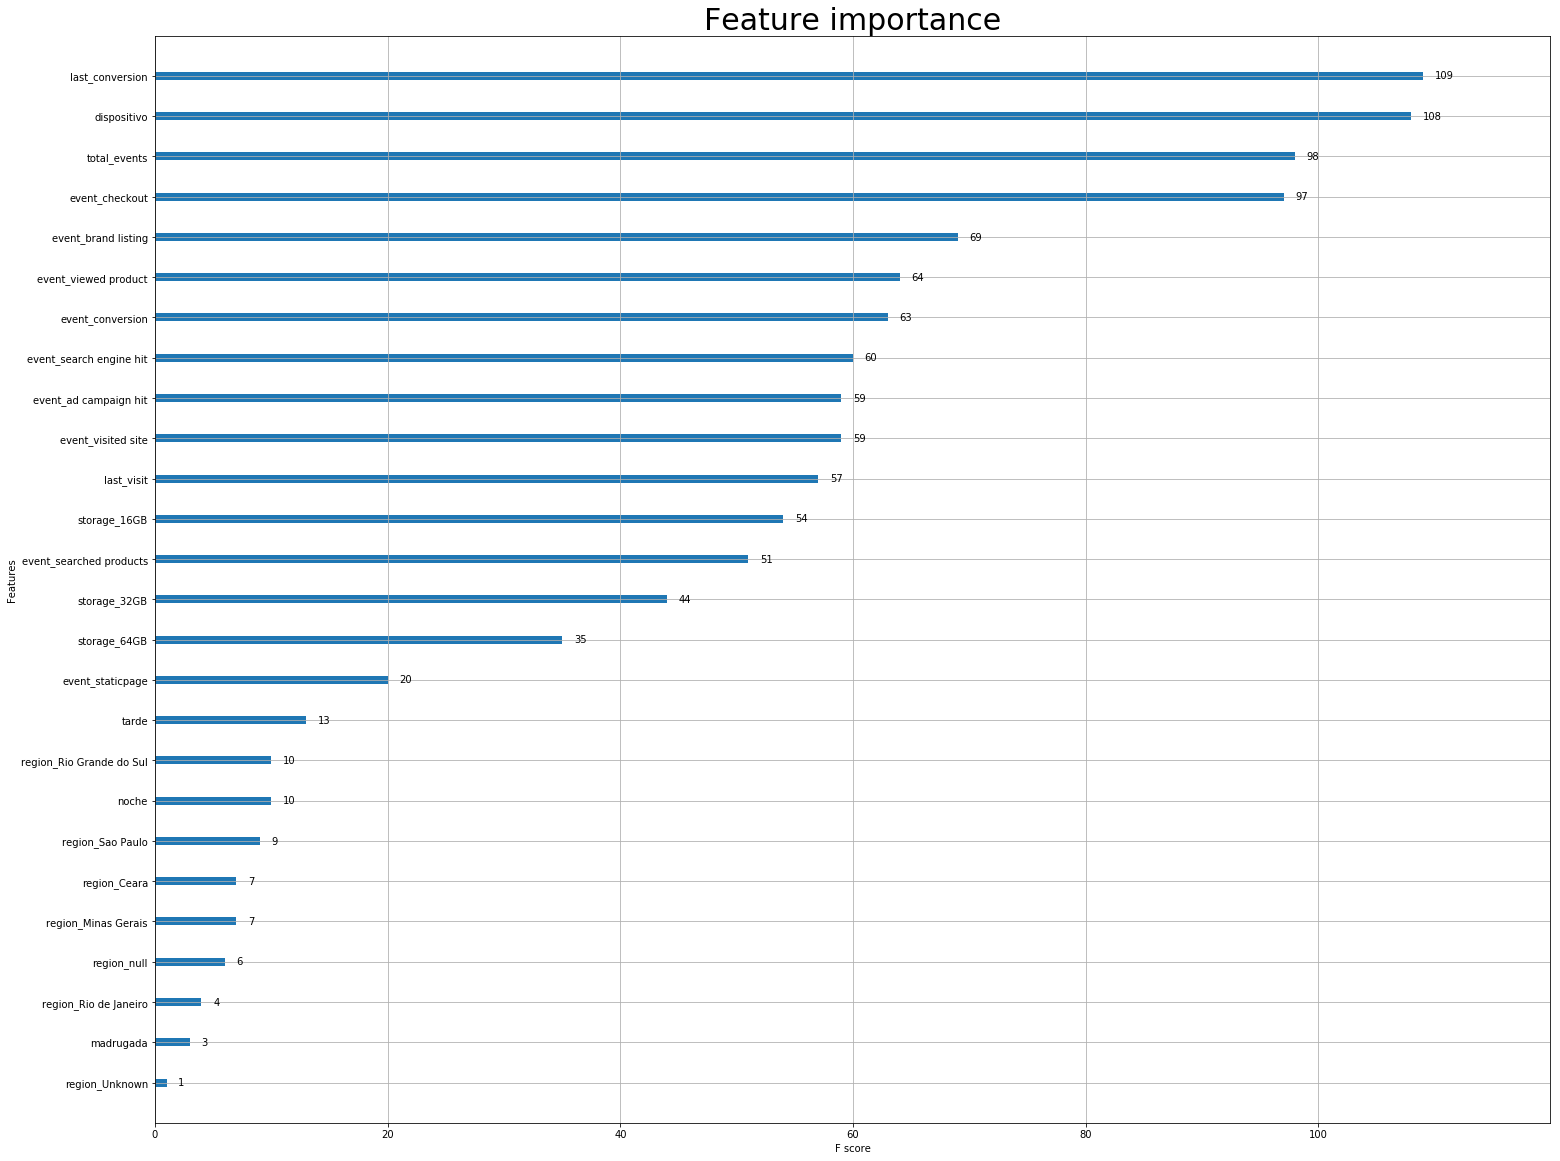

In [105]:
#Grafico la importancia de los features
xgb.plot_importance(XGBC)
plt.rcParams['figure.figsize'] = [30, 30]
plt.title('Feature importance', size = 30)
plt.show()